# Investigate Automobile Dataset

This report will include some efforts to infer some data about cars from 1985 Ward's Automotive Yearbook.<br>
Sources:
1. 1985 Model Import Car and Truck Specifications, 1985 Ward's Automotive Yearbook.
2. Personal Auto Manuals, Insurance Services Office, 160 Water Street, New York, NY 10038
3. Insurance Collision Report, Insurance Institute for Highway Safety, Watergate 600, Washington, DC 20037

This data set consists of three types of entities: (a) the specification of an auto in terms of various characteristics, (b) its assigned insurance risk rating, (c) its price and fuel consumption. The second rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale. Actuarians call this process "symboling". A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.

## Table of Contents
- [Introduction](#intro)
- [Data Wrangling](#data-wrangling)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)
- [Limitations](#limitations)


<a id='intro'></a>
## Introduction

In this report, we will try to perform a full data analysis procedure.<br>
We will:
1. Discover the data and perform some data wrangling. We might deduce some conclusions from our exploratory data analysis, but this is not our ultimate target.
2. We will perform some simple probability calculations to infer some conclusions.
3. We will use some hypothesis testing to check some hypotheses we might have.
4. We will finally build a regression model to tie it all up.

We will assume that the symboling, price and the mileage of the car are our dependant variables that we are trying to link with other variables.

<a id='data-wrangling'></a>
### Data Wrangling

We will start our data wrangling process by discovering our data, checking for NaNs or duplicates.
We will also perform some exploratory data analysis to understand the data under our hands.

In [1]:
#Let's start by importing our libraries

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.stats.proportion import proportions_ztest
from word2number import w2n
%matplotlib inline
random.seed(42)

In [2]:
df=pd.read_csv('Automobile_data.csv')
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


Let's replace in all column names the `-` by `_` to facilitate our analysis later on.

In [3]:
df.columns= df.columns.str.replace('-','_')

In [4]:
df[df.duplicated()]

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price


There are no duplicates, this is good news.<br>
We have noticed that some cells have the value `?`.<br>
This is probably due to the importing of data from another database using `?` instead of `NaN`, so let's correct that.

In [5]:
df.replace('?',np.nan,inplace=True)
df.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


In [6]:
df.shape

(205, 26)

We can now easily check for `NaN` values.

In [7]:
df[df.isin([np.nan]).any(axis=1)]

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
5,2,NaN,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.4,8.5,110,5500,19,25,15250
7,1,NaN,audi,gas,std,four,wagon,fwd,front,105.8,...,136,mpfi,3.19,3.4,8.5,110,5500,19,25,18920
9,0,NaN,audi,gas,turbo,two,hatchback,4wd,front,99.5,...,131,mpfi,3.13,3.4,7.0,160,5500,16,22,NaN
14,1,NaN,bmw,gas,std,four,sedan,rwd,front,103.5,...,164,mpfi,3.31,3.19,9.0,121,4250,20,25,24565
15,0,NaN,bmw,gas,std,four,sedan,rwd,front,103.5,...,209,mpfi,3.62,3.39,8.0,182,5400,16,22,30760
16,0,NaN,bmw,gas,std,two,sedan,rwd,front,103.5,...,209,mpfi,3.62,3.39,8.0,182,5400,16,22,41315
17,0,NaN,bmw,gas,std,four,sedan,rwd,front,110.0,...,209,mpfi,3.62,3.39,8.0,182,5400,15,20,36880


We can now easily deduce that most of the `NaN` values are in the `normalized_losses`.<br>
This is a very high number, so we cannot drop them without affecting the quality of the data.<br>
We will replace these values with the `mean` of `normalized_losses`

In [8]:
df = df.astype({'normalized_losses': 'float64'})
df['normalized_losses']=df['normalized_losses'].fillna(df['normalized_losses'].mean())
df[df.isin([np.nan]).any(axis=1)]

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
9,0,122.0,audi,gas,turbo,two,hatchback,4wd,front,99.5,...,131,mpfi,3.13,3.4,7.0,160,5500,16,22,NaN
27,1,148.0,dodge,gas,turbo,NaN,sedan,fwd,front,93.7,...,98,mpfi,3.03,3.39,7.6,102,5500,24,30,8558
44,1,122.0,isuzu,gas,std,two,sedan,fwd,front,94.5,...,90,2bbl,3.03,3.11,9.6,70,5400,38,43,NaN
45,0,122.0,isuzu,gas,std,four,sedan,fwd,front,94.5,...,90,2bbl,3.03,3.11,9.6,70,5400,38,43,NaN
55,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,...,70,4bbl,NaN,NaN,9.4,101,6000,17,23,10945
56,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,...,70,4bbl,NaN,NaN,9.4,101,6000,17,23,11845
57,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,...,70,4bbl,NaN,NaN,9.4,101,6000,17,23,13645
58,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,...,80,mpfi,NaN,NaN,9.4,135,6000,16,23,15645
63,0,122.0,mazda,diesel,std,NaN,sedan,fwd,front,98.8,...,122,idi,3.39,3.39,22.7,64,4650,36,42,10795
129,1,122.0,porsche,gas,std,two,hatchback,rwd,front,98.4,...,203,mpfi,3.94,3.11,10.0,288,5750,17,28,NaN


The rest of the NaN values, are distributed between the columns. More than half of them are in some of our dependant variables.<b>
We can just drop these rows.

In [9]:
df.dropna(inplace=True)

In [10]:
df.shape

(193, 26)

We will now check the `dtypes` of our columns and make the necessary adjustments.

In [11]:
df.dtypes

symboling              int64
normalized_losses    float64
make                  object
fuel_type             object
aspiration            object
num_of_doors          object
body_style            object
drive_wheels          object
engine_location       object
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight            int64
engine_type           object
num_of_cylinders      object
engine_size            int64
fuel_system           object
bore                  object
stroke                object
compression_ratio    float64
horsepower            object
peak_rpm              object
city_mpg               int64
highway_mpg            int64
price                 object
dtype: object

Below, we will use a ew function called `word_to_num` from a library called `w2n` to help us with the `num-of-doors` and `num-of-cylinders` columns which have numbers but written in letters.

In [12]:
df = df.astype({'wheel_base': 'float64', 'bore': 'float64', 'stroke': 'float64', 'horsepower': 'float64', 'peak_rpm': 'float64', 'price': 'float64'})
df['num_of_doors'] = df['num_of_doors'].apply(w2n.word_to_num)
df['num_of_cylinders'] = df['num_of_cylinders'].apply(w2n.word_to_num)

In [13]:
df = df.astype({'num_of_doors': 'int64', 'num_of_cylinders': 'int64'})

In [14]:
df.dtypes

symboling              int64
normalized_losses    float64
make                  object
fuel_type             object
aspiration            object
num_of_doors           int64
body_style            object
drive_wheels          object
engine_location       object
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight            int64
engine_type           object
num_of_cylinders       int64
engine_size            int64
fuel_system           object
bore                 float64
stroke               float64
compression_ratio    float64
horsepower           float64
peak_rpm             float64
city_mpg               int64
highway_mpg            int64
price                float64
dtype: object

In [15]:
df.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,122.0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,122.0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,122.0,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,4,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,4,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


Let's use the option below to see the whole extend of the dataset columns.
Do not worry, we will reset it in the end, in order not to mess with your settings.

In [16]:
pd.set_option('max_columns', None)
df.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,122.0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,122.0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,122.0,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,4,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,4,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


We can now start to **explore** our data.<br>
And let's start with our dependant variables so we can see their range.

In [17]:
df.symboling.value_counts().sort_index()

-2     3
-1    22
 0    63
 1    51
 2    31
 3    23
Name: symboling, dtype: int64

In [18]:
df[['price','city_mpg','highway_mpg']].describe()

,price,city_mpg,highway_mpg
count,193.000000,193.000000,193.000000
mean,13285.025907,25.326425,30.787565
std,8089.082886,6.387828,6.816910
min,5118.000000,13.000000,16.000000
25%,7738.000000,19.000000,25.000000
50%,10245.000000,25.000000,30.000000
75%,16515.000000,30.000000,34.000000
max,45400.000000,49.000000,54.000000


Now let's see some of the independant variables.

0.9015544041450777

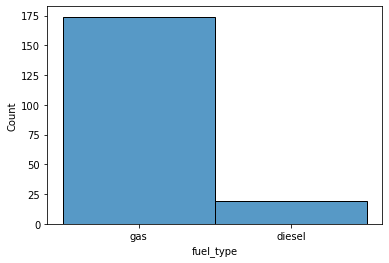

In [19]:
sns.histplot(df['fuel_type']);
(df[df['fuel_type']=='gas'].count()/df.shape[0])[0]

0.8186528497409327

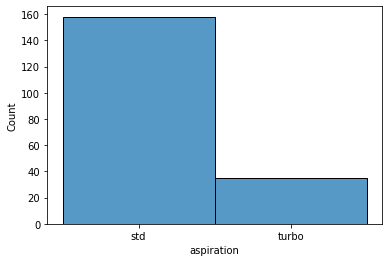

In [20]:
sns.histplot(df['aspiration']);
(df[df['aspiration']=='std'].count()/df.shape[0])[0]

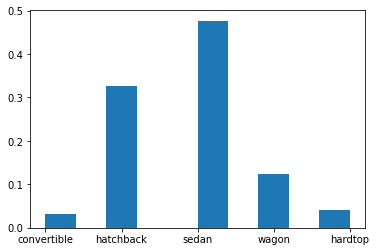

In [21]:
plt.hist(df['body_style'], weights=np.ones(len(df['body_style'])) / len(df['body_style']));

We can see a big difference between the top two types of `body_style`s and the rest.<br>
Let's see if there is relationship between this and the car's risk factor or `symboling`.

In [22]:
df.groupby(['body_style'])['symboling'].describe()

,count,mean,std,min,25%,50%,75%,max
body_style,,,,,,,,
convertible,6.0,2.833333,0.408248,2.0,3.00,3.0,3.00,3.0
hardtop,8.0,1.875000,0.991031,0.0,1.75,2.0,2.25,3.0
hatchback,63.0,1.523810,1.090385,-1.0,1.00,1.0,2.50,3.0
sedan,92.0,0.326087,1.006667,-2.0,0.00,0.0,1.00,2.0
wagon,24.0,-0.166667,0.637022,-1.0,-1.00,0.0,0.00,1.0


Generally sedans and wagons are the safest vehicles. But with the high standard deviation, we cannot be sure.<br>
A `boxplot` can be a better explanation.

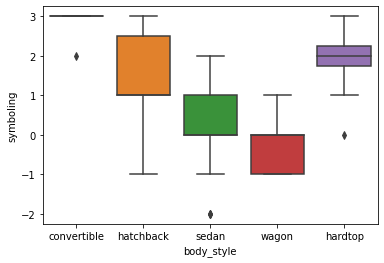

In [23]:
ax = sns.boxplot(x=df['body_style'], y=df['symboling'])

This confirms that wagons and sedans are the safest vehicles. But it also shows us that there is no enough data for the convertible cars.

In [24]:
df['engine_type'].value_counts()

ohc     141
ohcf     15
ohcv     13
dohc     12
l        12
Name: engine_type, dtype: int64

Let's now see the different car manufacturers.

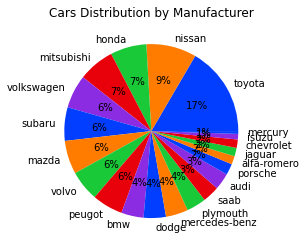

toyota           32
nissan           18
honda            13
mitsubishi       13
volkswagen       12
subaru           12
mazda            12
volvo            11
peugot           11
bmw               8
dodge             8
mercedes-benz     8
plymouth          7
saab              6
audi              6
porsche           4
alfa-romero       3
jaguar            3
chevrolet         3
isuzu             2
mercury           1
Name: make, dtype: int64

In [25]:
    labels = df['make'].value_counts().index.tolist()
    data = df['make'].value_counts().values.tolist()
    colors = sns.color_palette('bright')[0:5]
    plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    plt.title('Cars Distribution by Manufacturer')
    plt.show()
    df['make'].value_counts()

There are too many car manufacturers. We will not be able to easily use any of the methods below.<br>
Let's at least they car `make` effect on each dependant variable.

In [26]:
df.groupby(['make'])[['symboling','price','city_mpg','highway_mpg']].mean().sort_values(by='symboling', ascending=True)

,symboling,price,city_mpg,highway_mpg
make,,,,
volvo,-1.272727,18063.181818,21.181818,25.818182
peugot,0.000000,15489.090909,22.454545,26.636364
jaguar,0.000000,34600.000000,14.333333,18.333333
mercedes-benz,0.000000,33647.000000,18.500000,21.000000
bmw,0.375000,26118.750000,19.375000,25.375000
subaru,0.500000,8541.250000,26.333333,30.750000
toyota,0.562500,9885.812500,27.500000,32.906250
mazda,0.583333,9852.000000,27.833333,34.083333
honda,0.615385,8184.692308,30.384615,35.461538


Let's end this part by seeing the distribution of most of our numercial parameters.

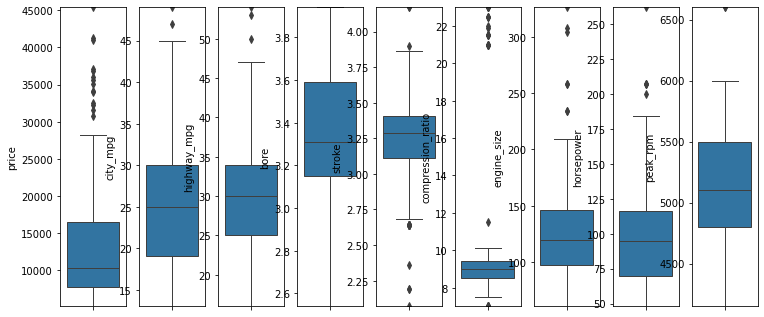

,price,city_mpg,highway_mpg,bore,stroke,compression_ratio,engine_size,horsepower,peak_rpm
mean,13285.025907,25.326425,30.787565,3.330622,3.248860,10.143627,128.124352,103.481865,5099.740933
std,8089.082886,6.387828,6.816910,0.272385,0.315421,3.977491,41.590452,37.960107,468.694369


In [27]:
    selection = [df.price, df['city_mpg'], df['highway_mpg'], df['bore'], df['stroke'], df['compression_ratio'], df['engine_size'], df['horsepower'], df['peak_rpm']]
    fig, axes = plt.subplots(1, len(selection))
    for i, col in enumerate(selection):
        ax = sns.boxplot(y=col, ax=axes.flatten()[i], linewidth=1)
        ax.set_ylim(col.min(), col.max())
    fig.set_size_inches(12.5, 5.5)
    #fig.tight_layout(pad=0.1)
    plt.show();
    df[['price','city_mpg','highway_mpg','bore','stroke','compression_ratio','engine_size','horsepower', 'peak_rpm']].describe().loc[['mean','std']]

<a id='probability'></a>
## Part I - Probability

To help us in the steps below, we will create bins for the price and the mileage.<br>
We will use the method below instead of `pd.cut` in order to have equally populated bins.

In [28]:
    def label_price (row):
       if np.percentile(df.price, 0)<=row['price']<np.percentile(df.price, 25):
          return 'Lowest Budget'
       if np.percentile(df.price, 25)<=row['price']<np.percentile(df.price, 50):
          return 'Low Budget'
       if np.percentile(df.price, 50)<=row['price']<np.percentile(df.price, 75):
          return 'High Budget'
       if np.percentile(df.price, 75)<=row['price']<=np.percentile(df.price, 100):
          return 'Highest Budget'
       return 'Other'
    df['price_range'] = df.apply (lambda row: label_price(row), axis=1)
    df[df['price_range']=='Other']

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price,price_range


In [29]:
def label_city_mpg (row):
   if np.percentile(df['city_mpg'], 0)<=row['city_mpg']<np.percentile(df['city_mpg'], 25):
      return 'Lowest City MPG'
   if np.percentile(df['city_mpg'], 25)<=row['city_mpg']<np.percentile(df['city_mpg'], 50):
      return 'Low City MPG'
   if np.percentile(df['city_mpg'], 50)<=row['city_mpg']<np.percentile(df['city_mpg'], 75):
      return 'High City MPG'
   if np.percentile(df['city_mpg'], 75)<=row['city_mpg']<=np.percentile(df['city_mpg'], 100):
      return 'Highest City MPG'
   return 'Other'
df['city_mpg_range'] = df.apply (lambda row: label_city_mpg(row), axis=1)
df[df['city_mpg_range']=='Other']

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price,price_range,city_mpg_range


In [30]:
def label_highway_mpg (row):
   if np.percentile(df['highway_mpg'], 0)<=row['highway_mpg']<np.percentile(df['highway_mpg'], 25):
      return 'Lowest Highway MPG'
   if np.percentile(df['highway_mpg'], 25)<=row['highway_mpg']<np.percentile(df['highway_mpg'], 50):
      return 'Low Highway MPG'
   if np.percentile(df['highway_mpg'], 50)<=row['highway_mpg']<np.percentile(df['highway_mpg'], 75):
      return 'High Highway MPG'
   if np.percentile(df['highway_mpg'], 75)<=row['highway_mpg']<=np.percentile(df['highway_mpg'], 100):
      return 'Highest Highway MPG'
   return 'Other'
df['highway_mpg_range'] = df.apply (lambda row: label_highway_mpg(row), axis=1)
df[df['highway_mpg_range']=='Other']

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price,price_range,city_mpg_range,highway_mpg_range


In [31]:
df.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price,price_range,city_mpg_range,highway_mpg_range
0,3,122.0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,High Budget,Low City MPG,Low Highway MPG
1,3,122.0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,High Budget,Low City MPG,Low Highway MPG
2,1,122.0,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,High Budget,Low City MPG,Low Highway MPG
3,2,164.0,audi,gas,std,4,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,High Budget,Low City MPG,High Highway MPG
4,2,164.0,audi,gas,std,4,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,Highest Budget,Lowest City MPG,Lowest Highway MPG


In [32]:
df[['price_range','city_mpg_range','highway_mpg_range']].value_counts().sort_values(ascending=False).head()

price_range     city_mpg_range    highway_mpg_range  
Lowest Budget   Highest City MPG  Highest Highway MPG    41
Highest Budget  Low City MPG      Low Highway MPG        20
High Budget     Low City MPG      Low Highway MPG        17
Highest Budget  Lowest City MPG   Lowest Highway MPG     17
High Budget     Low City MPG      Lowest Highway MPG     14
dtype: int64

From the analysis above, I can see that the top populated groups follow the rules where if you pay a high price, you will at least save some gas.<br>

Let's see the percentage of cars that are not in the same category for both city and highway fuel consumption.

In [33]:
df[(df['city_mpg_range']=='Highest City MPG') & (df['highway_mpg_range']!='Highest Highway MPG')].count()[0]/df.shape[0]

0.010362694300518135

In [34]:
df[(df['city_mpg_range']=='High City MPG') & (df['highway_mpg_range']!='High Highway MPG')].count()[0]/df.shape[0]

0.07772020725388601

In [35]:
df[(df['city_mpg_range']=='Low City MPG') & (df['highway_mpg_range']!='Low Highway MPG')].count()[0]/df.shape[0]

0.16580310880829016

In [36]:
df[(df['city_mpg_range']=='Lowest City MPG') & (df['highway_mpg_range']!='Lowest Highway MPG')].count()[0]/df.shape[0]

0.015544041450777202

That's very high. Good news !!<br> I do no tlike the group with the 16.6% percentage. Let's see that group.

In [37]:
df[(df['city_mpg_range']=='Low City MPG') & (df['highway_mpg_range']!='Low Highway MPG')].head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price,price_range,city_mpg_range,highway_mpg_range
3,2,164.0,audi,gas,std,4,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,High Budget,Low City MPG,High Highway MPG
23,1,118.0,dodge,gas,turbo,2,hatchback,fwd,front,93.7,157.3,63.8,50.8,2128,ohc,4,98,mpfi,3.03,3.39,7.6,102.0,5500.0,24,30,7957.0,Low Budget,Low City MPG,High Highway MPG
28,-1,110.0,dodge,gas,std,4,wagon,fwd,front,103.3,174.6,64.6,59.8,2535,ohc,4,122,2bbl,3.34,3.46,8.5,88.0,5000.0,24,30,8921.0,Low Budget,Low City MPG,High Highway MPG
29,3,145.0,dodge,gas,turbo,2,hatchback,fwd,front,95.9,173.2,66.3,50.2,2811,ohc,4,156,mfi,3.60,3.90,7.0,145.0,5000.0,19,24,12964.0,High Budget,Low City MPG,Lowest Highway MPG
75,1,122.0,mercury,gas,turbo,2,hatchback,rwd,front,102.7,178.4,68.0,54.8,2910,ohc,4,140,mpfi,3.78,3.12,8.0,175.0,5000.0,19,24,16503.0,High Budget,Low City MPG,Lowest Highway MPG


In general, we deduce that expensive cars consume less fuel. Let's see the ranges of the cars that do **not** follow this rule.

In [38]:
df[((df['price_range']=='Lowest Budget')|(df['price_range']=='Low Budget')) & ((df['city_mpg_range']=='Lowest City MPG')|(df['city_mpg_range']=='Low City MPG')) ].count()[0]/df.shape[0]

0.07772020725388601

In [39]:
df[((df['price_range']=='Highest Budget')|(df['price_range']=='High Budget')) & ((df['city_mpg_range']=='Highest City MPG')|(df['city_mpg_range']=='High City MPG')) ].count()[0]/df.shape[0]

0.08808290155440414

That's also not very high.

<a id='ab_test'></a>
## Part II - A/B Test

First idea we had is to do some A/B testing using the type of fuel. Do diesel fuelled cars consume less fuel than gas fuelled cars ? <br>
Data points for the diesel fuelled cars is too low. This is a huge **limitation** since with this number, we will not be able to use any inferrential statistics theories such as the central limit theorem.<br>
Although, the case is not so much different for the turbo charged cars, we will perform an approximation and use these data points since they are more than 20.

In [40]:
df[df['fuel_type']=='gas'].count()[0], df[df['fuel_type']=='diesel'].count()[0]

(174, 19)

In [41]:
df[df['aspiration']=='std'].count()[0], df[df['aspiration']=='turbo'].count()[0]

(158, 35)

In [42]:
df[df['aspiration']=='std']['city_mpg'].mean(),df[df['aspiration']=='turbo']['city_mpg'].mean() , df['city_mpg'].mean()

(25.943037974683545, 22.542857142857144, 25.326424870466322)

$$H_0: asp_{std} \leq asp_{turbo} $$
$$H_1: asp_{std} > asp_{turbo}$$

In [43]:
obs_diff = df[df['aspiration']=='std']['city_mpg'].mean() - df[df['aspiration']=='turbo']['city_mpg'].mean()
obs_diff

3.4001808318264004

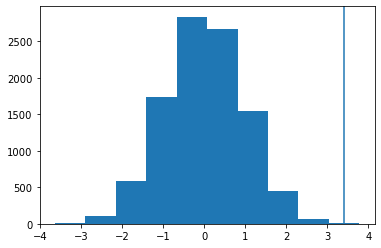

In [44]:
diffs=[]
for i in range(10000):
    df_std_asp=df[df['aspiration']=='std'].sample(df[df['aspiration']=='std'].count()[0], replace = True)
    df_turbo_asp=df[df['aspiration']=='turbo'].sample(df[df['aspiration']=='turbo'].count()[0], replace = True)
    sample_mean = df_std_asp['city_mpg'].mean()-df_turbo_asp['city_mpg'].mean()
    diffs.append(sample_mean)
diffs=np.array(diffs)
null_vals = np.random.normal(0,diffs.std(),10000)
plt.hist(null_vals)
plt.axvline(x=obs_diff);

In [45]:
(null_vals > obs_diff).mean()

0.0002

The very low p-value ($p<0.05$) tells us that we **can reject** the hypothesis that standard aspiration records less or same mileage per gallon than the turbo aspirated vehicles. This is for a confidence interval of **95%** or higher.<br>
This [study](https://www.caranddriver.com/features/a20776954/are-turbocharged-engines-a-fuel-economy-boost-or-a-fuel-economy-bust/) can be interesting for car lovers.<br>
Question is, is that difference practically relevant ? We are talking about a difference in means of 3.5 miles per gallon where the mean of the whole population is 25 miles per gallon. It seems that this difference is **relevant**.


Let's do one more study, are 2-door cars more **expensive** than 4-door cars ?

$$H_0: price_{4-door} \leq price_{2-door} $$
$$H_1: price_{4-door} > price_{2-door}$$

In [46]:
df[df['num_of_doors']==4].count()[0], df[df['num_of_doors']==2].count()[0]

(112, 81)

In [47]:
df[df['num_of_doors']==4]['price'].mean(),df[df['num_of_doors']==2]['price'].mean(), df['price'].mean()

(13603.80357142857, 12844.246913580248, 13285.025906735751)

In [48]:
obs_diff = df[df['num_of_doors']==4]['price'].mean() - df[df['num_of_doors']==2]['price'].mean()
obs_diff

759.5566578483231

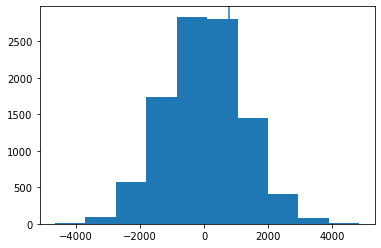

In [49]:
diffs=[]
for i in range(10000):
    df_four_door=df[df['num_of_doors']==4].sample(df[df['num_of_doors']==4].count()[0], replace = True)
    df_two_door=df[df['num_of_doors']==2].sample(df[df['num_of_doors']==2].count()[0], replace = True)
    sample_mean = df_four_door['price'].mean()-df_two_door['price'].mean()
    diffs.append(sample_mean)
diffs=np.array(diffs)
null_vals = np.random.normal(0,diffs.std(),10000)
plt.hist(null_vals)
plt.axvline(x=obs_diff);

In [50]:
(null_vals > obs_diff).mean()

0.2725

The high p-value ($p>0.05$) tells us that we **cannot reject** the hypothesis that 4-door cars are less or equally expensive than 2-door cars.<br>

<a id='regression'></a>
## Part III - A regression approach

How about we build a model linking some of the numerical variables.<br>
We will start simple. We will try to use `curb_weight`, `engine_size`, `compression_ratio`, `horsepower` and `peak-rpm` to deduce the `price` of the vehicle.

In [51]:
df['intercept']=1
lm=sm.OLS(df['price'],df[['intercept','curb_weight','engine_size','compression_ratio', 'horsepower', 'peak_rpm']])
result=lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     186.4
Date:                Thu, 10 Mar 2022   Prob (F-statistic):           1.16e-70
Time:                        14:14:26   Log-Likelihood:                -1837.4
No. Observations:                 193   AIC:                             3687.
Df Residuals:                     187   BIC:                             3706.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept         -2.694e+04   4256.586     -6.329      0.000   -3.53e+04   -1.85e+04
curb_weight           3.7762      0.994      3.800      0.000       1.816       5.737
engine_size         113.5163     14.756      7.693      0.000      84.406     142.627
compression_ratio   208.7944     73.391      2.845      0.005      64.013     353.575
horsepower           29.8694     15.701      1.902      0.059      -1.104      60.842
peak_rpm              2.1174      0.677      3.128      0.002       0.782       3.453
==============================================================================
Omnibus:                       13.885   Durbin-Watson:                   0.779
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               32.708
Skew:                           0.226   Prob(JB):                     7.90e-08
Kurtosis:                       4.966   Cond. No.                     1.01e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This has predicted the model by *83%* which is a high R-Squared value.<br>
We can see that the `curb_weight`, `engine_size`, `horsepower` and `peak_rpm` increase its price.<br>
`compression_ratio` is statistically irrelevant due to its high $p_{value}$
What if we try to include more parameters such as `wheel-base`, `length`, `width`, `height`, `bore` and `stroke` ?

In [52]:
lm=sm.OLS(df['price'],df[['intercept','curb_weight','engine_size','compression_ratio', 'horsepower','wheel_base','length','width','height','bore','stroke']])
result=lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     100.7
Date:                Thu, 10 Mar 2022   Prob (F-statistic):           1.14e-68
Time:                        14:14:26   Log-Likelihood:                -1828.9
No. Observations:                 193   AIC:                             3680.
Df Residuals:                     182   BIC:                             3716.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept         -4.999e+04    1.5e+04     -3.324      0.001   -7.97e+04   -2.03e+04
curb_weight           0.4504      1.595      0.282      0.778      -2.696       3.597
engine_size         109.5992     14.333      7.647      0.000      81.319     137.879
compression_ratio   187.8893     71.895      2.613      0.010      46.035     329.744
horsepower           68.4412     15.388      4.448      0.000      38.079      98.803
wheel_base           36.5888    105.023      0.348      0.728    -170.631     243.809
length              -59.2342     56.610     -1.046      0.297    -170.930      52.462
width               662.1777    263.847      2.510      0.013     141.585    1182.770
height              318.6884    146.726      2.172      0.031      29.185     608.191
bore              -1826.4791   1192.850     -1.531      0.127   -4180.073     527.115
stroke            -2747.2575    814.363     -3.374      0.001   -4354.065   -1140.450
==============================================================================
Omnibus:                       23.397   Durbin-Watson:                   0.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.519
Skew:                           0.272   Prob(JB):                     2.99e-21
Kurtosis:                       6.385   Cond. No.                     1.69e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This has only increased the accuray of our model by a little less than 2% with the `wheel_base`, `length` and `bore` all deemed statistically irrelevant.<br> But has this new model included any **multicollinearity** ?

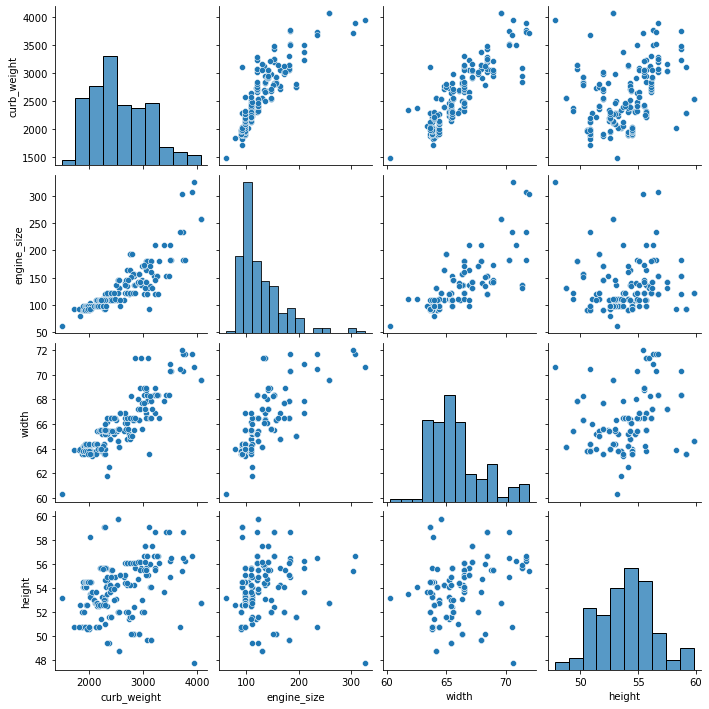

In [53]:
sns.pairplot(df[['curb_weight','engine_size','width','height']]);

The drawings say **Yes**.<br>
Different measures of car size including `engine_size`, `curb_Weight`, `width` and `height` are linearly related.
Will these factors really have a high **variance inflation factor** ?

In [54]:
features = "+".join(df[['curb_weight','engine_size','width','height','stroke','compression_ratio', 'horsepower']])
y, X = dmatrices('price ~ ' + features, df, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,3545.795781,Intercept
1,9.533001,curb_weight
2,6.269077,engine_size
3,4.162878,width
4,1.635173,height
5,1.119901,stroke
6,1.443272,compression_ratio
7,5.188672,horsepower


No features had a VIF factor higher than **20** so we will keep all features in our regression model.<br>
How about we build another model for the `highway-mpg`. This time, let's include the `drive_wheels`

In [55]:
df.drive_wheels.value_counts()

fwd    114
rwd     71
4wd      8
Name: drive_wheels, dtype: int64

Due to its low number, we will have to drop the `4wd` from our calculations.

In [56]:
df2=df[df['drive_wheels']!='4wd']
df2.drive_wheels.value_counts()

fwd    114
rwd     71
Name: drive_wheels, dtype: int64

In [57]:
df2['drive_wheels_dash']=2
df2['drive_wheels_dash']=df2.drive_wheels.apply(lambda x: 1 if x=='fwd' else 0)
df2.head()

C:\Temp/ipykernel_4084/4291840166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['drive_wheels_dash']=2
C:\Temp/ipykernel_4084/4291840166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['drive_wheels_dash']=df2.drive_wheels.apply(lambda x: 1 if x=='fwd' else 0)


,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price,price_range,city_mpg_range,highway_mpg_range,intercept,drive_wheels_dash
0,3,122.0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,High Budget,Low City MPG,Low Highway MPG,1,0
1,3,122.0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,High Budget,Low City MPG,Low Highway MPG,1,0
2,1,122.0,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,High Budget,Low City MPG,Low Highway MPG,1,0
3,2,164.0,audi,gas,std,4,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,High Budget,Low City MPG,High Highway MPG,1,1
5,2,122.0,audi,gas,std,2,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,5,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,15250.0,High Budget,Low City MPG,Low Highway MPG,1,1


In [58]:
lm=sm.OLS(df2['highway_mpg'],df2[['intercept','curb_weight','engine_size','compression_ratio','wheel_base','length','width','height','bore','stroke','drive_wheels_dash','peak_rpm', 'horsepower']])
result=lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            highway_mpg   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     87.66
Date:                Thu, 10 Mar 2022   Prob (F-statistic):           1.12e-66
Time:                        14:14:32   Log-Likelihood:                -437.59
No. Observations:                 185   AIC:                             901.2
Df Residuals:                     172   BIC:                             943.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            70.2291     13.365      5.255      0.000      43.848      96.610
curb_weight          -0.0095      0.002     -5.684      0.000      -0.013      -0.006
engine_size           0.0265      0.013      2.060      0.041       0.001       0.052
compression_ratio     0.4913      0.064      7.722      0.000       0.366       0.617
wheel_base            0.0066      0.093      0.070      0.944      -0.177       0.190
length               -0.0558      0.049     -1.141      0.255      -0.152       0.041
width                -0.0502      0.231     -0.218      0.828      -0.506       0.405
height                0.0220      0.131      0.168      0.867      -0.237       0.280
bore                 -0.7479      1.088     -0.687      0.493      -2.896       1.401
stroke                0.0840      0.717      0.117      0.907      -1.331       1.499
drive_wheels_dash    -0.3118      0.671     -0.465      0.643      -1.636       1.012
peak_rpm             -0.0010      0.001     -1.690      0.093      -0.002       0.000
horsepower           -0.0458      0.015     -3.036      0.003      -0.076      -0.016
==============================================================================
Omnibus:                       42.879   Durbin-Watson:                   1.570
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.155
Skew:                           0.852   Prob(JB):                     5.53e-34
Kurtosis:                       7.119   Cond. No.                     3.91e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.91e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
features = "+".join(df2[['intercept','curb_weight','engine_size','compression_ratio','wheel_base','length','width','height','bore','stroke','drive_wheels_dash','peak_rpm', 'horsepower']])
y, X = dmatrices('highway_mpg ~ ' + features, df2, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

C:\Users\maximfad\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
0,0.000000,Intercept
1,0.000000,intercept
2,20.622537,curb_weight
3,7.574941,engine_size
4,1.708326,compression_ratio
5,8.747050,wheel_base
6,9.888237,length
7,6.417698,width
8,2.495700,height
9,2.264529,bore


It seems that we need to remove `curb_weight`. Let's redo our model.

In [60]:
lm=sm.OLS(df2['highway_mpg'],df2[['intercept','engine_size','compression_ratio','wheel_base','length','width','height','bore','stroke','drive_wheels_dash','peak_rpm', 'horsepower']])
result=lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            highway_mpg   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     78.49
Date:                Thu, 10 Mar 2022   Prob (F-statistic):           2.84e-61
Time:                        14:14:32   Log-Likelihood:                -453.51
No. Observations:                 185   AIC:                             931.0
Df Residuals:                     173   BIC:                             969.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept           106.2897     12.784      8.315      0.000      81.058     131.522
engine_size           0.0033      0.013      0.252      0.801      -0.023       0.029
compression_ratio     0.3986      0.067      5.964      0.000       0.267       0.530
wheel_base           -0.0654      0.100     -0.652      0.515      -0.263       0.133
length               -0.1701      0.048     -3.512      0.001      -0.266      -0.074
width                -0.4531      0.239     -1.899      0.059      -0.924       0.018
height                0.0117      0.142      0.082      0.935      -0.269       0.293
bore                 -0.8044      1.183     -0.680      0.497      -3.139       1.530
stroke               -0.4585      0.772     -0.594      0.553      -1.982       1.065
drive_wheels_dash     1.0712      0.679      1.577      0.117      -0.269       2.412
peak_rpm             -0.0006      0.001     -0.900      0.369      -0.002       0.001
horsepower           -0.0777      0.015     -5.097      0.000      -0.108      -0.048
==============================================================================
Omnibus:                       23.274   Durbin-Watson:                   1.553
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.174
Skew:                           0.483   Prob(JB):                     3.16e-14
Kurtosis:                       5.670   Cond. No.                     3.08e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Some parameters were statistically inrrelevant due to high $p_{value}$ such as `wheel_base`,`engine_size`,`height`,`bore`,`stroke`, `drive_wheels_dash` and `peak_rpm`.<br>
`highway_mpg` increases with `compression_ratio`.
While all other relevant factors decrease the `highway_mpg`

<a id='conclusions'></a>
## Conclusions

<a id='conclusions'></a>
## Conclusions

We have done many different tests to infer as much conlusions as we can from the automobile data set.
For this we have used different methods.

1. Discover the data and perform some data wrangling.
2. A/B Hypothesis testing.
3. Build regression models to tie it all up.


|Independant Variable|`price`|`city_mpg`|`highway_mpg`|Comments|
| ------------- |:-------------:|:-----:| :-------------:  |---------|
|`normalized_losses`|-|-|-|Exploratory Data Analysis Performed|
|`make`|-|-|-|Exploratory Data Analysis Performed|
|`fuel_type`|-|-|-|Exploratory Data Analysis Performed; Bad data distribution|
|`aspiration`|-|A/B Test Performed|-|Exploratory Data Analysis Performed|
|`num_of_doors`|A/B Test Performed|-|-|-|
|`body_style`|-|-|-|Exploratory Data Analysis Performed|
|`drive_wheels`|-|-|Regression Model Created||-|
|`engine_location`|-|-|-|Bad data distibution|
|`wheel_base`|Regression Model Created|-|Regression Model Created|-|
|`length`|Regression Model Created|-|Regression Model Created|-|
|`width`|Regression Model Created|-|Regression Model Created|-|
|`height`|Regression Model Created|-|Regression Model Created|-|
|`curb_weight`|Regression Model Created|-|Regression Model Created|-|
|`engine_type`|-|-|-|-|
|`num_of_cylinders`|-|-|Regression Model Created|-|
|`engine_size`|Regression Model Created|-|-|Exploratory Data Analysis Performed|
|`fuel_system`|-|-|-|-|
|`bore`|Regression Model Created|-|Regression Model Created|Exploratory Data Analysis Performed|
|`stroke`|Regression Model Created|-|Regression Model Created|Exploratory Data Analysis Performed|
|`compression_ratio`|Regression Model Created|-|Regression Model Created|Exploratory Data Analysis Performed|
|`horsepower`|Regression Model Created|-|Regression Model Created|Exploratory Data Analysis Performed|
|`peak_rpm`|Regression Model Created|-|Regression Model Created|Exploratory Data Analysis Performed|


So finally, is there a clear relationship between `price` and `city_mpg` ?

C:\Users\maximfad\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


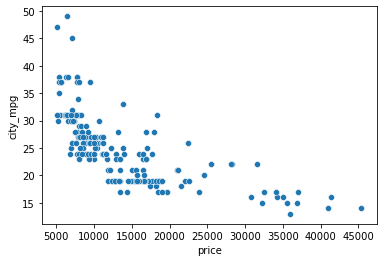

In [61]:
sns.scatterplot(df['price'],df['city_mpg']);

It seems that the relationship is inverse and medium.
Can we confirm this numerically ?

In [62]:
pearson_coef, p_value = stats.pearsonr(df['price'], df['city_mpg'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P = ", p_value) 

The Pearson Correlation Coefficient is -0.7066179934987951  with a P-value of P =  1.6533219288194736e-30


It seems that our assumption is correct.

<a id='limitations'></a>
## Limitations

1. There are too many car types with little number of cars in each type which makes it impossible to do any sofisticated inferrential statistics.
2. There are too little gas fuelled cars so we we not able to relate the `fuel` type to our analysis.
3. The above is the same for `engine_location`.

In [63]:
pd.reset_option('max_columns')
df.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price,price_range,city_mpg_range,highway_mpg_range,intercept
0,3,122.0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,...,9.0,111.0,5000.0,21,27,13495.0,High Budget,Low City MPG,Low Highway MPG,1
1,3,122.0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,...,9.0,111.0,5000.0,21,27,16500.0,High Budget,Low City MPG,Low Highway MPG,1
2,1,122.0,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,...,9.0,154.0,5000.0,19,26,16500.0,High Budget,Low City MPG,Low Highway MPG,1
3,2,164.0,audi,gas,std,4,sedan,fwd,front,99.8,...,10.0,102.0,5500.0,24,30,13950.0,High Budget,Low City MPG,High Highway MPG,1
4,2,164.0,audi,gas,std,4,sedan,4wd,front,99.4,...,8.0,115.0,5500.0,18,22,17450.0,Highest Budget,Lowest City MPG,Lowest Highway MPG,1
